In [35]:
%matplotlib inline
import csv
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict

#### 全結合層

In [2]:
class Linear:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        #self.dW = np.dot(self.x[None,:].T, dout[None,:])
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

#### sigmoid関数

In [3]:
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        out = 1/ (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1 - self.out) * self.out
        return dx

#### Relu関数

In [4]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

#### network全体のクラス

In [75]:
class MLP_init:
    def __init__(self, input_size, hidden_size, output_size):
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.random.randn(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.random.randn(output_size)
        
        self.layers = OrderedDict()
        self.layers['Linear1'] = Linear(self.params['W1'], self.params['b1'])
        self.layers['Sigmoid1'] = Sigmoid()
        self.layers['Linear2'] = Linear(self.params['W2'], self.params['b2'])
        self.layers['Sigmoid2'] = Sigmoid()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        t = np.eye(7)[t-1]
        y = self.predict(x)
        return 1/2 * np.sum((y - t) ** 2)
    
    def accuracy(self, x, t):
        y = np.argmax(self.predict(x), axis = 1)
        acc = np.sum(y == t)/float(x.shape[0])
        return acc
    
    def gradient(self, x, t):
        #backward
        t = np.eye(7)[t-1]
        dout = self.predict(x) - t
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        grads = {}
        grads['W1'] = self.layers['Linear1'].dW
        grads['b1'] = self.layers['Linear1'].db
        grads['W2'] = self.layers['Linear2'].dW
        grads['b2'] = self.layers['Linear2'].db
        
        return grads

#### データの読み込み

In [111]:
data_dict = {}
label_dict = {}
for x in range(1,16):
    x = str(x)
    data_dict[x] = []
    label_dict[x] = []
    file_path = '/Users/isonoyuma/python_workspace/work_later/data_set/Activity Recognition from Single Chest-Mounted Accelerometer/{}.csv'.format(x)
    with open(file_path, newline="")as f:
        read = csv.reader(f, delimiter=',')
        for row in read:
            data_dict[x].append([int(data) for data in row[1:4]])
            label_dict[x].append(int(row[4]))
            
    
    first_info = data_dict[x][-1]
    data_dict[x].pop(-1)
    label_dict[x].pop(-1)
    data_dict[x] = np.array(data_dict[x])
    data_dict[x] = data_dict[x] - first_info
    #prepro-start
    max_abs_scaler = preprocessing.MaxAbsScaler()
    data_dict[x] = max_abs_scaler.fit_transform(data_dict[x])
    #prepro-end
    label_dict[x] = np.array(label_dict[x])

100%|██████████| 10000/10000 [01:26<00:00, 115.40it/s]


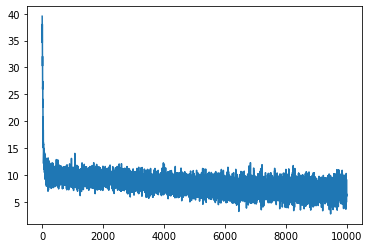

In [112]:
network = MLP_init(input_size=3, hidden_size=7, output_size=7)
X_train, X_test, y_train, y_test = train_test_split(data_dict["1"], label_dict["1"], test_size=0.4)
iters_num = 10000
learning_rate = 0.005
batch_size = 30
train_size = X_train.shape[0]
train_loss_list = []
train_acc_list = []
test_acc_list = []

for x in tqdm(range(iters_num)):
    X_train, X_test, y_train, y_test = train_test_split(data_dict["1"], label_dict["1"], test_size=0.4)
    batch_mask = np.random.choice(train_size, batch_size)#変更点
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    grad = network.gradient(X_batch, y_batch)
    for key in ['W1', 'b1', 'W2', 'b2']:
            network.params[key] -= learning_rate * grad[key]
    train_loss_list.append(network.loss(X_batch, y_batch))
    if x % 100 == 0:
        train_acc = network.accuracy(X_train, y_train)
        test_acc = network.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
plt.plot(train_loss_list)

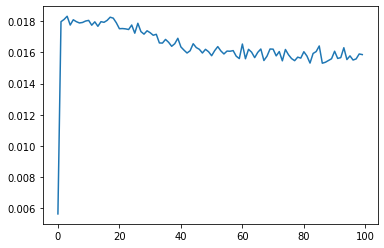

In [113]:
plt.plot(train_acc_list)

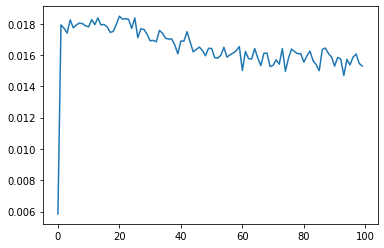

In [114]:
plt.plot(test_acc_list)